# Aplicação de Modelos Neurais de Recomendação ao Contexto dos Jogos Eletrônicos

## Comparação entre:

Modelo | Metodologia de Recomendação | Aprendizagem Profunda
-------|-----------------------------|----------------------
ItemKNN | Filtragem Colaborativa | Não
ItemAttributeKNN | Filtragem Baseada em Conteúdo | Não
BPR-MF | Ranqueamento Orientado a Pares | Não
LightGCN | Filtragem Colaborativa | Sim
NCF | Filtragem Colaborativa | Sim
Wide and Deep | Filtragem Híbrida | Sim
xDeepFM | Filtragem Híbrida | Sim



# Aquisição dos conjuntos de dados

In [ ]:
# Download do pacote do Kaggle
! pip install -q kaggle

In [ ]:
# Em sua conta do Kaggle, gere uma chave de API: isso fornecerá 
# um arquivo "kaggle.json". Faça upload dele nesta célula
from google.colab import files
files.upload()

In [ ]:
# Processamento da licença
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Importação dos conjuntos de dados
! kaggle datasets download 'forgemaster/steam-reviews-dataset'
! kaggle datasets download 'nikdavis/steam-store-games'

100% 1.93G/1.93G [02:24<00:00, 17.5MB/s]
100% 1.93G/1.93G [02:24<00:00, 14.4MB/s]
 94% 33.0M/35.2M [00:02<00:00, 18.9MB/s]
100% 35.2M/35.2M [00:02<00:00, 13.1MB/s]


In [ ]:
%%capture

# Unzip dos dados
! mkdir data
! unzip steam-reviews-dataset.zip -d data
! unzip steam-store-games.zip -d data

# Dependências

In [ ]:
%%capture

# Microsoft Recommender
! pip install recommenders[examples]

# Case Recommender
! pip install caserecommender

In [ ]:
# Ciência de dados geral
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Para treinar os modelos neurais
from tempfile import TemporaryDirectory
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Manipulação de arquivos
import os

In [ ]:
# Caminhos dos arquivos finais
REVIEWS_DATA_PATH = "./data/reviews.csv"
GAMES_DATA_PATH = "./data/games.csv"
GAME_NAMES_DATA_PATH = "./data/game_names.csv"

# Caminhos dos arquivos de treino/validação/teste
TRAIN_DATA_PATH = "./data/train.csv"
TEST_DATA_PATH = "./data/test.csv"
TRAIN2_DATA_PATH = "./data/train2.csv"
TEST2_DATA_PATH = "./data/test2.csv"

# Semente de geração pseudoaleatória
RANDOM_SEED = 16

# Pré-processamento dos dados

In [ ]:
# Arquivos de interações explícitas
reviews_file_names = [name for name in os.listdir("./data/") if "reviews-" in name]

# Função de carregamento e de seleção de colunas
def load_and_process_data(file_name):
    reviews = pd.read_csv("./data/" + file_name)
    reviews = reviews.drop(axis=1, labels=reviews.columns[3:])
    return reviews

# Leitura, processamento e concatenação dos arquivos
reviews = load_and_process_data(reviews_file_names[0])
for i in range(1, len(reviews_file_names)):
    next_reviews = load_and_process_data(reviews_file_names[i])
    reviews = pd.concat((reviews, next_reviews))

reviews

,steamid,appid,voted_up
0,76561198097123877,535760,False
1,76561198007480200,535760,True
2,76561198294124356,535760,True
3,76561198035233570,535760,False
4,76561197996374111,535760,True
...,...,...,...
1962060,76561198031757552,402330,True
1962061,76561197968447924,402330,True
1962062,76561198040776450,402330,True
1962063,76561198186396395,402330,True


In [ ]:
# Leitura dos dados
games = pd.read_csv("./data/steam.csv")

# Separação dos nomes dos jogos
game_names = pd.DataFrame(games[["appid", "name"]])
games = games.drop(axis=1, labels="name")

''' COMENTAR PARA MANTER SOMENTE GÊNEROS DOS JOGOS
# release_date --> year
games["year"] = games.release_date.apply(lambda x: x[:4])
games = games.drop(axis=1, labels="release_date")

# owners --> avg_owners
games["average_owners"] = games.owners.apply(lambda x: str(x).split('-')[1])
games = games.drop(axis=1, labels="owners")

# platforms --> one-hot encoding
platforms = games.platforms.str.get_dummies(';')
games = games.join(platforms)
games = games.drop(axis=1, labels="platforms")

# categories --> one-hot encoding
categories = pd.get_dummies(games.categories.str.get_dummies(";"))
games = games.join(categories)
games = games.drop(axis=1, labels="categories")
'''

# genres --> one-hot encoding; 
# drop steamspy_tags
# drop developer and publisher (too many different categorical values)
genres = games.genres.str.get_dummies(";")
games = games.join(genres)
games = games.drop(axis=1, labels=["genres", "steamspy_tags", "developer", "publisher"])

# Manter somente categorias
games = games.drop(axis=1, labels=games.columns[1:13])

games

,appid,Accounting,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Documentary,Early Access,...,Sexual Content,Simulation,Software Training,Sports,Strategy,Tutorial,Utilities,Video Production,Violent,Web Publishing
0,10,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27071,1065570,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,1065650,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27073,1066700,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Mantém somente as reviews de jogos presentes no dataset acima
reviews = reviews[reviews.appid.isin(games.appid.values)]
reviews = reviews.groupby("steamid").filter(lambda x: len(x) > 48) # Redução de exemplos para poder utilizar a RAM
reviews = reviews.groupby("appid").filter(lambda x: len(x) > 32) 
games = games[games.appid.isin(reviews.appid.unique())]

# Mapeamento dos ids e das notas
mapper = dict([(steamid, idx) for idx, steamid in enumerate(reviews.steamid.unique())])
reviews.steamid = reviews.steamid.map(mapper)
reviews.voted_up = reviews.voted_up.map({True:1, False:0})

# Mapeamento dos ids dos jogos
mapper = dict([appid, idx] for idx, appid in enumerate(games.appid.unique()))
reviews.appid = reviews.appid.map(mapper)
games.appid = games.appid.map(mapper)

# Mudança dos nomes das colunas do conjunto de avaliações
# Semelhança com o conjunto Movielens é necessária para alguns dos métodos
reviews.columns = ['userID', 'itemID', 'rating']

# Salvamento das bases de dados
reviews.to_csv(REVIEWS_DATA_PATH, index=False)
games.to_csv(GAMES_DATA_PATH, index=False, header=True)

reviews.shape, games.shape

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


((358270, 3), (2541, 30))

In [ ]:
# Separação em treino e teste
train, test = train_test_split(reviews, test_size=0.2, random_state=RANDOM_SEED)

# Garante estabilidade dos métodos
print("train size:", train.shape[0])
print("previous test size:", test.shape[0])
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]
print("current test size:", test.shape[0])

# Ordenação por ID de usuário
train = train.sort_values(by="userID")
test = test.sort_values(by="userID")

# Salvamento (para os modelos tradicionais, que não aceitam Header)
train.to_csv(TRAIN_DATA_PATH, index=False, header=False)
test.to_csv(TEST_DATA_PATH, index=False, header=False)

# Salvamento (para os modelos neurais, que requerem Header)
train.to_csv(TRAIN2_DATA_PATH, index=False, header=True)
test.to_csv(TEST2_DATA_PATH, index=False, header=True)

train size: 286616
previous test size: 71654
current test size: 71654


# Treino e avaliação dos modelos -- métodos tradicionais

## ItemKNN (filtragem colaborativa baseada em vizinhança)

In [ ]:
from caserec.recommenders.item_recommendation.itemknn import ItemKNN

K_NEIGHBORS = 10

# Uso do ItemKNN
itemKNN_model = ItemKNN (
    train_file=TRAIN_DATA_PATH, 
    test_file=TEST_DATA_PATH, 
    sep=',',
    k_neighbors=K_NEIGHBORS, 
    similarity_metric='jaccard', 
    as_similar_first=True
)

itemKNN_model.compute()

[Case Recommender: Item Recommendation > ItemKNN Algorithm]

train data:: 5502 users and 2541 items (286616 interactions) | sparsity:: 97.95%
test data:: 5501 users and 2541 items (71654 interactions) | sparsity:: 99.49%

training_time:: 40.979982 sec
prediction_time:: 171.869102 sec


Eval:: PREC@1: 0.233049 PREC@3: 0.188026 PREC@5: 0.164697 PREC@10: 0.135085 RECALL@1: 0.019229 RECALL@3: 0.045768 RECALL@5: 0.066848 RECALL@10: 0.108361 MAP@1: 0.233049 MAP@3: 0.311156 MAP@5: 0.325265 MAP@10: 0.318559 NDCG@1: 0.233049 NDCG@3: 0.384005 NDCG@5: 0.416683 NDCG@10: 0.435705 


## ItemAttributeKNN (filtragem baseada em conteúdo)

In [ ]:
from caserec.recommenders.item_recommendation.item_attribute_knn import ItemAttributeKNN

K_NEIGHBORS = 10

# Uso do ItemAttributeKNN
itemAttributeKNN_model = ItemAttributeKNN (
    train_file=TRAIN_DATA_PATH, 
    test_file=TEST_DATA_PATH, 
    metadata_file=GAMES_DATA_PATH, 
    sep=',', 
    metadata_similarity_sep=',',
    k_neighbors=K_NEIGHBORS, 
    similarity_metric='jaccard', 
    as_similar_first=True
)

itemAttributeKNN_model.compute()

[Case Recommender: Item Recommendation > Item Attribute KNN Algorithm]

train data:: 5502 users and 2541 items (286616 interactions) | sparsity:: 97.95%
test data:: 5501 users and 2541 items (71654 interactions) | sparsity:: 99.49%

training_time:: 3.050307 sec
>> metadata:: 2541 items and 1 metadata (2541 interactions) | sparsity:: 0.00%
prediction_time:: 158.808016 sec


Eval:: PREC@1: 0.01836 PREC@3: 0.012967 PREC@5: 0.014252 PREC@10: 0.015724 RECALL@1: 0.001301 RECALL@3: 0.002542 RECALL@5: 0.004699 RECALL@10: 0.010879 MAP@1: 0.01836 MAP@3: 0.02439 MAP@5: 0.027754 MAP@10: 0.032739 NDCG@1: 0.01836 NDCG@3: 0.030331 NDCG@5: 0.037637 NDCG@10: 0.051782 


## BPR-MF (ranqueamento orientado a pares)

In [ ]:
from caserec.recommenders.item_recommendation.bprmf import BprMF

FACTORS = 10

# Uso o BPR-MF
bprmf_model = BprMF (
    train_file=TRAIN_DATA_PATH, 
    test_file=TEST_DATA_PATH, 
    sep=',', 
    random_seed=RANDOM_SEED, 
    learn_rate=1e-3, 
    factors=FACTORS,
)

bprmf_model.compute()

[Case Recommender: Item Recommendation > BPRMF]

train data:: 5502 users and 2541 items (286616 interactions) | sparsity:: 97.95%
test data:: 5501 users and 2541 items (71654 interactions) | sparsity:: 99.49%

training_time:: 243.586778 sec
prediction_time:: 7.275083 sec


Eval:: PREC@1: 0.093619 PREC@3: 0.08041 PREC@5: 0.076859 PREC@10: 0.06746 RECALL@1: 0.007729 RECALL@3: 0.019167 RECALL@5: 0.030076 RECALL@10: 0.053109 MAP@1: 0.093619 MAP@3: 0.143322 MAP@5: 0.160201 MAP@10: 0.169452 NDCG@1: 0.093619 NDCG@3: 0.19079 NDCG@5: 0.225672 NDCG@10: 0.257169 


# Treino e avaliação dos modelos -- métodos neurais

In [ ]:
%%capture

! pip install tf_slim

In [ ]:
# Dependências
from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k

In [ ]:
# Leitura dos arquivos
train = pd.read_csv(TRAIN2_DATA_PATH)
test = pd.read_csv(TEST2_DATA_PATH)

## Neural Collaborative Filtering

In [ ]:
# Hiperparâmetros
TOP_K = 10
BATCH_SIZE = 256

# Dados
ncf_data = NCFDataset(train_file=TRAIN2_DATA_PATH, test_file=TEST2_DATA_PATH, seed=RANDOM_SEED)

# Modelo
ncf_model = NCF (
    n_users=ncf_data.n_users, 
    n_items=ncf_data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    n_epochs=24,
    verbose=6,
    seed=RANDOM_SEED
)

100%|██████████| 5501/5501 [02:12<00:00, 41.40it/s]
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
# Treinamento
with Timer() as train_time:
    ncf_model.fit(ncf_data)
print("Took {} seconds for training.".format(train_time))

Took 216.1411 seconds for training.


In [ ]:
# Teste
with Timer() as test_time:

    # Cálculo das notas
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(ncf_model.predict(user, item, is_list=True)))

    # Para mesclar os resultados
    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})
    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

Took 31.9986 seconds for prediction.


In [ ]:
# Métricas de desempenho
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
print("MAP:\t%f" % eval_map, "NDCG:\t%f" % eval_ndcg)

MAP:	0.031306 NDCG:	0.103455


## Wide & Deep

In [ ]:
# Dependências
import sys
import math
import itertools
import sklearn.preprocessing
from tempfile import TemporaryDirectory
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
from recommenders.utils.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
    DEFAULT_GENRE_COL as ITEM_FEAT_COL,
    SEED
)
from recommenders.utils import tf_utils, gpu_utils, plot
import recommenders.evaluation.python_evaluation as evaluator
import recommenders.models.wide_deep.wide_deep_utils as wide_deep


# ---------- Parameters ----------

# Recommend top k items
TOP_K = 10

# Metrics to use for evaluation
RANKING_METRICS = [
    evaluator.ndcg_at_k.__name__,
    evaluator.map_at_k.__name__,
]
RATING_METRICS = [
    evaluator.rmse.__name__,
    evaluator.mae.__name__,
]

# Use session hook to evaluate model while training
EVALUATE_WHILE_TRAINING = True

# Train and test set pickle file paths. If provided, use them. Otherwise, download the MovieLens dataset.
DATA_DIR = None
TRAIN_PICKLE_PATH = None
TEST_PICKLE_PATH = None
EXPORT_DIR_BASE = os.path.join("outputs", "model")

# Model checkpoints directory. If None, use temp-dir.
MODEL_DIR = None


# ---------- Hyperparameters ----------

MODEL_TYPE = "wide_deep"
STEPS = 50000  # Number of batches to train
BATCH_SIZE = 32
# Wide (linear) model hyperparameters
LINEAR_OPTIMIZER = "adagrad"
LINEAR_OPTIMIZER_LR = 0.0621  # Learning rate
LINEAR_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
LINEAR_L2_REG = 0.0
LINEAR_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# DNN model hyperparameters
DNN_OPTIMIZER = "adadelta"
DNN_OPTIMIZER_LR = 0.1
DNN_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
DNN_L2_REG = 0.0
DNN_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# Layer dimensions. Defined as follows to make this notebook runnable from Hyperparameter tuning services like AzureML Hyperdrive
DNN_HIDDEN_LAYER_1 = 0     # Set 0 to not use this layer
DNN_HIDDEN_LAYER_2 = 64    # Set 0 to not use this layer
DNN_HIDDEN_LAYER_3 = 128   # Set 0 to not use this layer
DNN_HIDDEN_LAYER_4 = 512   # Note, at least one layer should have nodes.
DNN_HIDDEN_UNITS = [h for h in [DNN_HIDDEN_LAYER_1, DNN_HIDDEN_LAYER_2, DNN_HIDDEN_LAYER_3, DNN_HIDDEN_LAYER_4] if h > 0]
DNN_USER_DIM = 32          # User embedding feature dimension
DNN_ITEM_DIM = 16          # Item embedding feature dimension
DNN_DROPOUT = 0.8
DNN_BATCH_NORM = 1         # 1 to use batch normalization, 0 if not.


# ---------- Model verifier ----------

if MODEL_DIR is None:
    TMP_DIR = TemporaryDirectory()
    model_dir = TMP_DIR.name
else:
    if os.path.exists(MODEL_DIR) and os.listdir(MODEL_DIR):
        raise ValueError(
            "Model exists in {}. Use different directory name or "
            "remove the existing checkpoint files first".format(MODEL_DIR)
        )
    TMP_DIR = None
    model_dir = MODEL_DIR

In [ ]:
# Modificação dos dados para adequar ao Wide & Deep
genres = pd.read_csv(GAMES_DATA_PATH)
genres[ITEM_FEAT_COL] = genres[genres.columns[1:].to_list()].values.tolist()
item_feat_shape = len(genres[ITEM_FEAT_COL][0])
print(item_feat_shape)
genres = genres[["appid", ITEM_FEAT_COL]]
genres.rename(columns={"appid" : "itemID"}, inplace=True)
genres.head()

29


,itemID,genre
0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Mesclagem
merged_train = pd.merge(train, genres, on="itemID", how="inner")
merged_test = pd.merge(test, genres, on="itemID", how="inner")
merged_train

,userID,itemID,rating,genre
0,0,2145,1,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
1,23,2145,1,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
2,27,2145,1,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
3,52,2145,1,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
4,71,2145,0,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...,...
286611,5325,179,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
286612,5351,179,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
286613,5380,179,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
286614,5440,179,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


In [ ]:
# Usuários e itens únicos
users = pd.DataFrame(data=merged_train[USER_COL].unique(), columns=[USER_COL])
items = pd.DataFrame(data=merged_train[ITEM_COL].unique(), columns=[ITEM_COL])
users

,userID
0,0
1,23
2,27
3,52
4,71
...,...
5497,517
5498,537
5499,1605
5500,2602


Obs.: as linhas de código 47 a 52 em wide_deep_utils.py resultam em erro devido a um bug no tensorflow ("tensorflow/contrib/layers/python/layers/feature_column.py in the _EmbeddingColumn class"). Impossível utilizar o código.





In [ ]:
# Create model checkpoint every n steps. We store the model 5 times.
save_checkpoints_steps = max(1, STEPS // 5)

# Define wide (linear) and deep (dnn) features
wide_columns, deep_columns = wide_deep.build_feature_columns(
    users=users,
    items=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
    item_feat_col=ITEM_FEAT_COL,
    crossed_feat_dim=1000,
    user_dim=DNN_USER_DIM,
    item_dim=DNN_ITEM_DIM,
    item_feat_shape=item_feat_shape,
    model_type=MODEL_TYPE,
)

print("Wide feature specs:")
for c in wide_columns:
    print("\t", str(c)[:100], "...")
print("Deep feature specs:")
for c in deep_columns:
    print("\t", str(c)[:100], "...")

ValueError: ignored

In [ ]:
# Build a model based on the parameters
model = wide_deep.build_model(
    model_dir=model_dir,
    wide_columns=wide_columns,
    deep_columns=deep_columns,
    linear_optimizer=tf_utils.build_optimizer(LINEAR_OPTIMIZER, LINEAR_OPTIMIZER_LR, **{
        'l1_regularization_strength': LINEAR_L1_REG,
        'l2_regularization_strength': LINEAR_L2_REG,
        'momentum': LINEAR_MOMENTUM,
    }),
    dnn_optimizer=tf_utils.build_optimizer(DNN_OPTIMIZER, DNN_OPTIMIZER_LR, **{
        'l1_regularization_strength': DNN_L1_REG,
        'l2_regularization_strength': DNN_L2_REG,
        'momentum': DNN_MOMENTUM,  
    }),
    dnn_hidden_units=DNN_HIDDEN_UNITS,
    dnn_dropout=DNN_DROPOUT,
    dnn_batch_norm=(DNN_BATCH_NORM==1),
    log_every_n_iter=max(1, STEPS//10),  # log 10 times
    save_checkpoints_steps=save_checkpoints_steps,
    seed=RANDOM_SEED
)

In [ ]:
from recommenders.datasets.pandas_df_utils import user_item_pairs

cols = {
    'col_user': USER_COL,
    'col_item': ITEM_COL,
    'col_rating': RATING_COL,
    'col_prediction': PREDICT_COL,
}

# Prepare ranking evaluation set, i.e. get the cross join of all user-item pairs
ranking_pool = user_item_pairs (
    user_df=users,
    item_df=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
    user_item_filter_df=train,  # Remove seen items
    shuffle=True,
    seed=RANDOM_SEED
)

In [ ]:
# Define training hooks to track performance while training
hooks = []
if EVALUATE_WHILE_TRAINING:
    evaluation_logger = tf_utils.MetricsLogger()
    for metrics in (RANKING_METRICS, RATING_METRICS):
        if len(metrics) > 0:
            hooks.append(
                tf_utils.evaluation_log_hook(
                    model,
                    logger=evaluation_logger,
                    true_df=test,
                    y_col=RATING_COL,
                    eval_df=ranking_pool if metrics==RANKING_METRICS else test.drop(RATING_COL, axis=1),
                    every_n_iter=save_checkpoints_steps,
                    model_dir=model_dir,
                    eval_fns=[evaluator.metrics[m] for m in metrics],
                    **({**cols, 'k': TOP_K} if metrics==RANKING_METRICS else cols)
                )
            )

# Define training input (sample feeding) function
train_fn = tf_utils.pandas_input_fn(
    df=train,
    y_col=RATING_COL,
    batch_size=BATCH_SIZE,
    num_epochs=None,  # We use steps=TRAIN_STEPS instead.
    shuffle=True,
    seed=RANDOM_SEED,
)

In [ ]:
%%time

 
print(
    "Training steps = {}, Batch size = {} (num epochs = {})"
    .format(STEPS, BATCH_SIZE, (STEPS*BATCH_SIZE)//len(train))
)

# Treino

try:
    model.train(
        input_fn=train_fn,
        hooks=hooks,
        steps=STEPS
    )
except tf.train.NanLossDuringTrainingError:
    import warnings
    warnings.warn(
        "Training stopped with NanLossDuringTrainingError. "
        "Try other optimizers, smaller batch size and/or smaller learning rate."
    )


# Comparativo


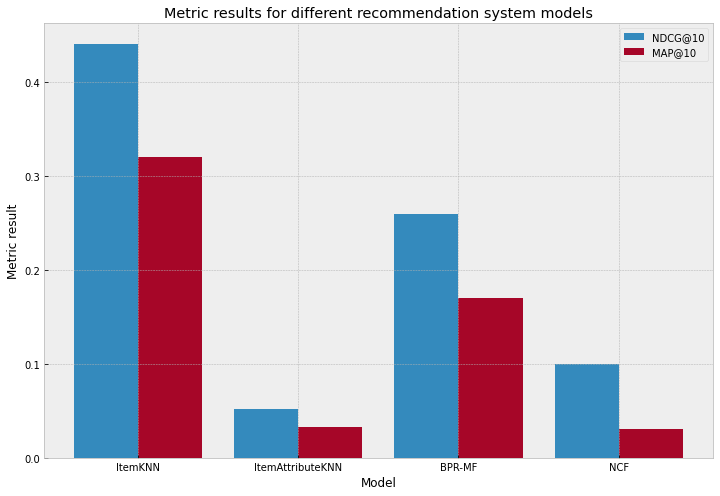

In [ ]:
# Dados dos algoritmos
labels = ["ItemKNN", "ItemAttributeKNN", "BPR-MF", "NCF"]
ndcg_10 = [0.44, 0.052, 0.26, 0.1]
map_10 = [0.32, 0.033, 0.17, 0.031]
x_range = np.arange(len(labels))

# Estilização
plt.style.use("bmh")

# Plot
plt.figure(figsize=(12,8))
plt.bar(x_range-0.2, ndcg_10, 0.4, label="NDCG@10")
plt.bar(x_range+0.2, map_10, 0.4, label="MAP@10")
plt.xticks(x_range, labels)
plt.xlabel("Model")
plt.ylabel("Metric result")
plt.title("Metric results for different recommendation system models")
plt.legend()
plt.show()